# Discrete-time Extended Kalman

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmms = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)S

2022-02-01 13:52:32,611 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-02-01 13:52:33,534 - root - INFO - ** Kedro project wPCC_pipeline
2022-02-01 13:52:33,534 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-01 13:52:33,548 - root - INFO - Registered line magic `run_viz`


E:\dev\wPCC_pipeline\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
E:\dev\wPCC_pipeline\venv\lib\site-packages\mlflow\types\schema.py:49: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary = (7, np.dtype("bytes"), "BinaryType", np.object)


In [2]:
from wPCC_pipeline.pipelines.preprocess.nodes import filter, assemble_data, add_thrust
from wPCC_pipeline.pipelines.extended_kalman.nodes import create_extended_kalman
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import extended_kalman_filter,extended_kalman_smoother

$$\dot{x} = f(x,u,w)$$
$$y = h(x,u) + \epsilon$$



```{prf:algorithm} Discrete-time extended Kalman filter
:label: ek-algorithm

**Inputs** Initial values: $x_0$, $P_0$, $C_d$, $R_d$, $Q_d$, $E_d$  

**Output** Estimated states: $\hat{x}$, estimated covariances $\hat{P}$

1. Initial values:
    1. $\hat{x}^-[0] = x_0$ 
    2. $\hat{P}^-[0] = P_0$

2. For $k$ in $n$ measurements

    1. KF gain
        1. $K[k]=\hat{P}^-[k] C_d^T \left(C_d \hat{P}^-[k] C_d^T + R_d\right)^{-1}$
        2. $I_{KC} = I_n - K[k] C_d$
        
    2. Update
        1. State corrector
            $\hat{x}[k] = \hat{x}^-[k] + K[k] eps$ ($eps = y - C_d \hat{x}^-[k]$)
        2. Covariance corrector
            $\hat{P}[k] = I_{KC} \cdot \hat{P}^-[k] I_{KC}^T + K[k] R_d K^T $
            
    3. Predict
        1. State predictor
            $\hat{x}^-[k+1] = \hat{x}[k] + h \cdot \hat{f}(\hat{x}[k], u[k], w[k])$
        2. Covariance predictor
            $\hat{P}^-[k+1] = A_d  \hat{P}[k] A_d^T + E_d Q_d E_d^T $
            

	
```

In [7]:
#id = 22612
id = 22613
data_raw = catalog.load(f"{id}.raw_data")

2022-02-01 13:53:18,550 - kedro.io.data_catalog - INFO - Loading data from `22613.raw_data` (CSVDataSet)...


In [8]:
thrust_channels = catalog.load("params:thrust_channels")
data_with_thrust = add_thrust(df=data_raw, thrust_channels=thrust_channels)
df_lowpass = filter(df=data_with_thrust, cutoff=10, order=1)

2022-02-01 13:53:19,171 - kedro.io.data_catalog - INFO - Loading data from `params:thrust_channels` (MemoryDataSet)...


In [9]:
df_data = assemble_data(df_lowpass=df_lowpass, raw_data=data_raw)

In [10]:
ship_data = catalog.load("ship_data")
vmm = catalog.load("vmm_martin")
                   
parameters = initial_parameters(ship_data=ship_data)

ek = create_extended_kalman(parameters=parameters, ship_data=ship_data, vmm = vmm) 

2022-02-01 13:53:33,872 - kedro.io.data_catalog - INFO - Loading data from `ship_data` (YAMLDataSet)...
2022-02-01 13:53:33,874 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin` (PickleDataSet)...


In [11]:
variance_u = 0.1
variance_v = 0.1
variance_r = np.deg2rad(0.1)
Qd = np.diag([variance_u, variance_v, variance_r])  # process variances: u,v,r

error_max_pos = 0.05
sigma_pos = error_max_pos / 3
variance_pos = sigma_pos ** 2

error_max_psi = np.deg2rad(0.5)
sigma_psi = error_max_psi / 3
variance_psi = sigma_psi ** 2

Rd = np.diag([variance_pos, variance_pos, variance_psi])
P_prd = np.diag(
    [
        variance_pos,
        variance_pos,
        variance_psi,
        variance_u,
        variance_v,
        variance_r,
    ]
)

covariance_matrixes = {
        "P_prd": P_prd.tolist(),
        "Qd": Qd.tolist(),
        "Rd": Rd.tolist(),
    }


ek_filtered, data_ek_filter = extended_kalman_filter(ek=ek, data=df_data, covariance_matrixes=covariance_matrixes)

In [12]:
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek)

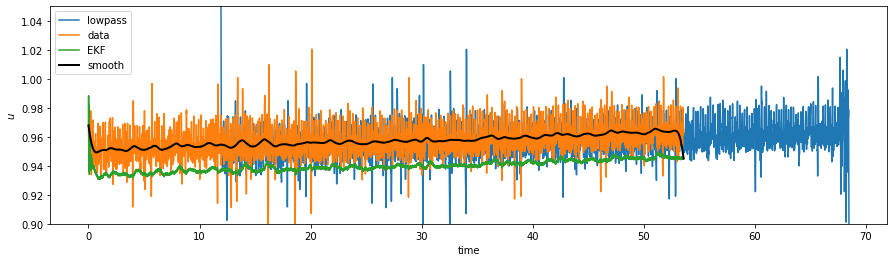

In [16]:
fig,ax=plt.subplots()

df_lowpass.plot(y='u', label='lowpass', ax=ax)
df_data.plot(y='u', label='data', ax=ax)
data_ek_filter.plot(y='u', label='EKF', ax=ax)
data_ek_smooth.plot(y='u', label='smooth', style='k-', lw=2, ax=ax)

ax.set_ylim(0.9,1.05)
ax.set_ylabel('$u$');